In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import sys
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (LabelEncoder, FunctionTransformer,
                                   OneHotEncoder, OrdinalEncoder,
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, cross_validate)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, precision_score,
                             make_scorer)
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from itertools import combinations
from xgboost import XGBClassifier

%matplotlib inline

## Overview

Pandemics have occured throughout history, each time affecting a large portion of the population. The most recent case being the Covid-19 2020 outbreak which resulted in a prolonged change in peoples day to day life, a lack or resources, and ultimately many deaths all around the world. If possible governments will do their best to try and prevent any future outbreaks by observing and learning from past information.     

Therefore our stakeholder, a government agency, is trying to plan for future pandemic prevention and awareness by using the 2009 H1N1 pandemic as an example. They would like us to observe which features of a survey completed at the time appear to hold the highest importance in people who did not recieve the H1N1 vaccine. With this information they are hoping to be able to concentrate their efforts to provide vaccination information and flu prevention methods to a group that was otherwise more succeptible to contracting the virus. These efforts will be performed in hopes of increasing the vaccination rates and to help limit the spread of future viruses.

---

## Business Understanding

Our stakeholders goal is to help in the prevention of future pandemics by spreading vaccination and prevention information. To increase the value of their efforts they would like to target the population that are less inclined to receive the vaccination. The most successful outcome would be the prevention of a widespread outbreak resulting in a pandemic, but more realisticly an increase in vaccination awareness that results in a higher rate of people receiving vaccinations in case another outbreak occurs.

Therefore this projects requirements are to define the target audience who are less inclined to receive a vaccination. In order to do so a data on people who have both received and refrained from receiving vaccinations in the past is required. Available to us is a survey conducted for the 2009 H1N1 pandemic. The H1N1 outbreak was first detected in the United States and quickly spread across the rest of the world resuliting in between 151,000 and 575,000 deaths worldwide. Unlike prior strains of the H1N1 virus, people under 65 were more affected than the older population. Around 80 percent of the deaths assumed caused by this strain of H1N1 were people under the age of 65. Since this strain differend from previous strains the seasonal flu vaccinations didn't offer protection from the virus causing a late production of a vaccine that would be affective. An affective vaccination didn't get mass produced until after a second wave of the virus had come and gone in the United States <a href="#h1n1_cdc_article">[1]</a>.

Due to these factors this dataset may stray from a typical case, reason being: 

1. <strong>The late emergence of the mass produced vaccine.</strong> It wasn't until after the second outbreak had passed that it was available, possibly causing people to assume the worst was over and a vaccination wasn't required and lowering the number of vaccinations.

2. <strong>The age group most affected were people under 65.</strong> This isn't typical for outbreaks and may have caused the number of vaccinations in this age group to be inflated.

Though our dataset may not reflect these two points, they should be kept in mind while analyzing the results. As far as metrics to qualify our models performance, I believe accuracy and precision should be used. A result of having high precision will ensure that our feature importance will strongly relate to true positive entries. Though there should be a fine balance and recall shouldn't be completely forgone. While we don't want our predicted positives to contain many false positives, we would like to predict a good portion of out true positive entries. By approaching our problem by utilizing our metrics in this manner we can assure that our stakeholder is targeting the correct audience.


---

## Data Understanding

As mentioned earlier in the business understanding section, the data being used for this analysis will be a 2009 survey conducted for the H1N1 outbreak. This survey was performed by the CDC in order to monitor and evaluate the flu vaccination efforts amount adults and children. The participants were parts of randomly called US households. The questions asked the participants dealt with their H1N1 vaccination status, flu-related behaviors, opinions about flue vaccine safety and effectivenss, recent respiratory illness, and pneumococcal vaccination status <a href="#About the National Immunization Survery">[2]</a>.

A detailed explanation of the features included in this survey can be found <a href="https://github.com/cschneck7/phase_3_project/blob/main/data/H1N1%20and%20Seasonal%20Flu%20Vaccines%20Feature%20Information.txt">here</a> or <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/">here</a>.
<!--  link need to fitted to github repository when pushed -->

The following data from the survey can be found and downloaded <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/data/">here</a> <a href="#Source Data Download">[3]</a>

In [2]:
# Import survey data into dataframes
# The source dataset already had this split feature and target files
X = pd.read_csv('data/source_data/training_set_features.csv')
y = pd.read_csv('data/source_data/training_set_labels.csv')

The `training_set_labels.csv` file read to `y` contains two target variables, `h1n1_vaccine` and `seasonal_vaccine1`. For this project only the `h1n1_vaccine` target variable will be used.

In [3]:
# Sets target variable
y = y.h1n1_vaccine

In [4]:
# Checks distribution of target variable
print(y.value_counts())
print(y.value_counts(normalize=True))

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


Around 79% of those who were surveyed did not receive the vaccination. 

Let't take a look at the featuers.

In [5]:
# preview of feature dataframe
X.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


We don't need the `respondent_id` column, so it will be dropped.

In [6]:
# drops respondent_id column
X.drop('respondent_id', axis=1, inplace=True)

# preview at feature column information
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

This datasets contains 26,707 entries and 35 features. The features have been inputted as either float64 or object types, 23 and 12 columns of those types respectively. As mentioned in the <a href="https://github.com/cschneck7/phase_3_project/blob/main/data/H1N1%20and%20Seasonal%20Flu%20Vaccines%20Feature%20Information.txt">feature description</a> file, the float64 column types are either encoded or binary where Yes=1 and No=0. It can also be observed from the above information that there are many missing values.

In [7]:
# Checks amount of Nan values in feature dataframe
missing_values = X.isna().sum()
missing_values

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Almost all columns are missing values, and some are missing nearly half of their values missing. These columns may be dropped later while the others are filled in. 

In [8]:
# Saving columns with many missing entries for later
many_missing = missing_values[missing_values > 12000]

Now lets check correlation between our target variable and features. We will be using a Chi2 test, with alpha=.05 and our null hypothesis being that there is no relationship between our feature and target variable.

Hypothesis:<br><br>
&emsp;&emsp;<strong>H<sub>0</sub></strong>: No relationship between the feature and target variable
<br>
&emsp;&emsp;<strong>H<sub>1</sub></strong>: There is a relationship between the feature and target variable   

In [9]:
def ordered_chi2(features, target='features', ascending=True, alpha=None):
    '''
    Returnes the ordered chi2 P-values between each feature and the target variable or variables
    
    Inputs: features = Dataframe of features
            target = pd.Series as target or default = 'features' which results in 
            finding relationships inside features DataFrame
            ascending = Determines order, default value = True
            alpha = Chi2 Pvalue threshold for which features get returned.
                        Returns all features with a Pvalue<=alpha,
                        default = None so all features are returned
            
    Output: Dataframe containing ordered P-values
    '''
    
    df = pd.DataFrame(columns=['var1', 'var2', 'Pvalue'])
                 
    if isinstance(target, pd.Series):
        for col in features.columns:
            temp_dict={}
            temp_dict['var1'] = target.name
            temp_dict['var2'] = col
            temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(target, features[col]))[1]
            df = df.append(temp_dict, ignore_index=True)
    
    elif target == 'features':
        combs = combinations(features.columns, 2)
        for comb in combs:
            temp_dict={}
            temp_dict['var1'] = comb[0]
            temp_dict['var2'] = comb[1]
            temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(features[comb[0]], features[comb[1]]))[1]
            df = df.append(temp_dict, ignore_index=True)
        
    else:
        sys.exit('''Incorrect input for parameter target.
        Parameter only accepts types pd.DataFrame, pd.Series, or left to default value.''')        
    
    if alpha == None:
        return df.sort_values(by='Pvalue', ascending=ascending)
    else:
        return df[df.Pvalue <= alpha].sort_values(by='Pvalue', ascending=ascending)

In [10]:
ordered_chi2(X, y)

,var1,var2,Pvalue
19,h1n1_vaccine,opinion_seas_risk,0.000000e+00
16,h1n1_vaccine,opinion_h1n1_risk,0.000000e+00
15,h1n1_vaccine,opinion_h1n1_vacc_effective,0.000000e+00
9,h1n1_vaccine,doctor_recc_h1n1,0.000000e+00
10,h1n1_vaccine,doctor_recc_seasonal,7.176678e-237
18,h1n1_vaccine,opinion_seas_vacc_effective,1.719836e-218
33,h1n1_vaccine,employment_industry,5.786809e-175
34,h1n1_vaccine,employment_occupation,2.021881e-172
13,h1n1_vaccine,health_worker,4.345311e-164
1,h1n1_vaccine,h1n1_knowledge,8.631658e-87


The above dataframe tells us that all but two features have failed the null hypothesis (H<sub>0</sub>) and are significant to our target variable. The two features that ended up being insignificant are `household_children` and `census_msa`.

The top six features in terms of significance were:

- `opinion_seas_risk`
- `opinion_h1n1_risk`
- `opinion_h1n1_vacc_effective`
- `doctor_recc_h1n1`
- `doctor_recc_seasonal`
- `opinion_seas_vacc_effective`

A theme of the top six is that there are basically three topics, asked each about the H1N1 flu and Seasonal flu. The initial assumption is that these pairs may be highly correlated. Let's confirm this by checking the correlation of all features using the Chi2 test again with an alpha of .05. The hypothesis are similar to the previous test between features and target variable.

Hypothesis:<br><br>
&emsp;&emsp;<strong>H<sub>0</sub></strong>: No relationship between the two features
<br>
&emsp;&emsp;<strong>H<sub>1</sub></strong>: There is a relationship between the two features 

In [11]:
alpha=.05
chi2_df = ordered_chi2(X, alpha=alpha)
chi2_df

,var1,var2,Pvalue
594,employment_industry,employment_occupation,0.000000
534,race,hhs_geo_region,0.000000
383,health_worker,employment_industry,0.000000
528,education,employment_occupation,0.000000
527,education,employment_industry,0.000000
...,...,...,...
347,child_under_6_months,opinion_seas_vacc_effective,0.030892
123,behavioral_avoidance,employment_status,0.035881
90,behavioral_antiviral_meds,marital_status,0.042447
376,health_worker,marital_status,0.044544


According to the DataFrame above, many features are correlated. There are a total of 573 instances of high correlation between features. Considering we have many missing values to deal with, the high correlation between certain features may help us fill in some missing data. Let's check if our assumption about the questions related to both the H1N1 and Seasonal flu having high multicollinearty is true.

In [12]:
similar_features = [['doctor_recc_h1n1', 'doctor_recc_seasonal'],
                    ['opinion_h1n1_vacc_effective', 'opinion_seas_vacc_effective'],
                    ['opinion_h1n1_risk', 'opinion_seas_risk'],
                    ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']]

for pair in similar_features:
    pvalue = "{:e}".format(float(chi2_df.loc[((chi2_df.var1 == pair[0]) & (chi2_df.var2 == pair[1])) |
                ((chi2_df.var2 == pair[0]) & (chi2_df.var1 == pair[1])), 'Pvalue']))
    print(f'({pair[0]}, {pair[1]}) : {pvalue}')

(doctor_recc_h1n1, doctor_recc_seasonal) : 0.000000e+00
(opinion_h1n1_vacc_effective, opinion_seas_vacc_effective) : 0.000000e+00
(opinion_h1n1_risk, opinion_seas_risk) : 0.000000e+00
(opinion_h1n1_sick_from_vacc, opinion_seas_sick_from_vacc) : 0.000000e+00


As seen above our assumptions were correct, for all cases we can reject the null hypothesis of the features having no relationship.

## Data Preparation

Now that we have a better understanding of our data, let's prepare it for our models. 

We'll start with dropping columns and row containing many missing entries. We already found the columns that fit this criteria earlier. While we are performing this all duplicate entries will be dropped.

In [13]:
X_prep = X.copy()

X_prep.drop(many_missing.index, axis=1, inplace=True)

# Drops duplicate entries if any exist
df_all = pd.concat([X_prep, y], axis=1).drop_duplicates()
X_prep = df_all.drop(y.name, axis=1)
y_prep = df_all[y.name]

print(f'Original number of entries: {X.shape[0]}')
print(f'Number of entries after dropped Duplicates: {X_prep.shape[0]}')

Original number of entries: 26707
Number of entries after dropped Duplicates: 26707


There weren't any duplicate entries.

Before we start editing more values and rows lets create a train-test split to prevent data leakage.

In [14]:
# Creates training and test splits to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=.25, random_state=42)

Now lets check how many rows are missing many values.

In [15]:
def missing_row_entries(df):
    '''
    Prints a DataFrame where:
        index = num of nan entries in a row
        frequency = number of rows with amount of nans defined by index
        cum_sum = cumulative sum starting with rows with most missing entries
        
    inputs: df = DataFrame with missing entries
    output: DataFrame, with nan per row information
    '''
    
    # Creates a list with number of missing values in each row
    nan_per_row = []
    for i in range(df.shape[0]):
        nan_per_row.append(df.iloc[i,:].isna().sum())
       
    # creates dataseries of missing values
    nan_per_row_ds = pd.Series(nan_per_row)
    nan_per_row_ds.rename('frequency', inplace=True)
    
    # gets frequeny of nan amounts in rows
    nan_row_counts = nan_per_row_ds.value_counts()
    
#     Orders nan_row_counts descending by most nans down
    ordered_missing_nan = nan_row_counts[nan_row_counts.keys().sort_values(ascending=False)]
    
#     Creates dataseries with cumulative sum
    nan_cum_sum = np.cumsum(ordered_missing_nan)   
    nan_cum_sum.rename('cum_sum', inplace=True)
    
#     Creates DataFrame with rows per missing values amount, and cum sum
    nan_df = pd.concat([ordered_missing_nan, nan_cum_sum], axis=1)
    nan_df.rename_axis('num_of_nans_in_row', inplace=True)
    
    return nan_df

In [16]:
# Find row missing nan information
missing_row_entries(X_train)

,frequency,cum_sum
num_of_nans_in_row,,
19,2,2
18,32,34
17,11,45
16,103,148
15,13,161
14,90,251
13,28,279
12,35,314
11,39,353


Our current features dataframe has 32 features after dropping those four columns. That means around 353 entries are missing about a third (11 values) of their features information. Since these entries are missing most of their information lets drop them from the dataset.

In [17]:
def drop_rows_by_nans(df, y, nan_threshold=None):
    '''
    Drop rows by quantity of nan values with nan_threshold as cut-off point
    
    Inputs: 
            df = DataFrame to be altered, should contain features and target concatenated together
            y = target variable column name
            nan_threshold = cut-off point to drop rows, default = None which results in a value
                            of half or a little larger than number of features
    
    Outputs: 
            feature_df = feature DataFrame
            y = Target Variable
    '''
    
#     Checks value of nan_threshold
    if nan_threshold == None:
#         Sets to half of or rounded up from half of feature columns
        nan_threshold = math.ceil((len(df.columns)-1)/2)
    
#     Finds nans contained in each row 
    nan_per_row = []
    for i in range(df.shape[0]):
        nan_per_row.append(df.iloc[i,:].isna().sum())
    
#     Creates temporary column in df for number of nan values
    df['nans'] = nan_per_row
#     Creates dataframe of rows under nan threshold
    df = df[df.nans < nan_threshold]
#     Creates target variable
    y = df.h1n1_vaccine
#     returns tuple (feature_df, target)
    return (df.drop(['nans', 'h1n1_vaccine'], axis=1), y)

In [18]:
# Creates custom fuction transfromer
Many_Nans_Row_Drop_FT = FunctionTransformer(drop_rows_by_nans, kw_args = {'y': 'h1n1_vaccine',
                                                                          'nan_threshold': 11})

In [19]:
# Creates combined set of both features and target to be transformed
train_df = pd.concat([X_train, y_train], axis=1).copy()

# Transforms training set
X_train_mod, y_train_mod = Many_Nans_Row_Drop_FT.fit_transform(train_df)

# Checks change in shape to ensure proper amount of entries were dropped
X_train.shape[0] - X_train_mod.shape[0]

353

Our object columns now need to be encoded for later use in our models.

In [34]:
# Creates dataframe of object types
X_train_mod_obj = X_train_mod.select_dtypes(include='object').copy()

# Creates dataframe of numerical features
X_train_mod_num = X_train_mod.select_dtypes(exclude='object').copy()

# Initialized ordinal encoder object with output data specified as type int64
# oe = OrdinalEncoder(dtype='int64')
oe = OrdinalEncoder()

# Creates dataframe of ordinal encoded data
X_train_mod_obj = pd.DataFrame(data = oe.fit_transform(X_train_mod_obj),
                                columns=X_train_mod_obj.columns,
                                index=X_train_mod_obj.index)

# Checks newly encoded dataframe
X_train_mod_obj.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
25194,0.0,0.0,3.0,0.0,NaN,1.0,0.0,1.0,8.0,2.0
14006,2.0,3.0,3.0,0.0,NaN,0.0,NaN,0.0,6.0,0.0
11285,2.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0
2900,3.0,2.0,3.0,1.0,2.0,1.0,0.0,0.0,7.0,0.0
19083,0.0,NaN,3.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0


In [35]:
X_train_enc = pd.concat([X_train_mod_obj, X_train_mod_num], axis=1)

Let's now try and fill in the rest of our missing values. Earlier we noticed that many variables had high colinearity with each other, we can use this to help us fill in for missing values. Our first attempt at filling the values will be through classification using the other features.

Issue with this process is the existence of missing values, many models in scikit-learn libraries cannot handle Nan values. Therefore random imputation will be used to fill in the feature information. The values will be randomly selected using existing values and their rate of appearances in the features existing values. After that is completed an iterative Decision Tree Classifier will be used to fill the randomly imputed values with predicted values.

This process was modified from Shashanka Subrahmanya's process for a regression model in his article <a href="https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression">Missing Data Imputation using Regression</a> <a href='#Missing Data Imputation using Regression'>[4]</a>. His process utilized linear regression and didn't create custom transfomers. For the purpose of this project I have modified it to fit my needs.

In [20]:
class RandomImputer(BaseEstimator, TransformerMixin):
    '''
    Randomly imputes values for missing data in new columns.
    Values are based off of existing values and rates of occurences.
    
    Initialized with optional parameter columns which mark which
    columns will be transformed, if left to default value 'all', all
    columns with missing values will be filled.
    '''
    
#     Initializes class object
    def __init__(self, missing_columns='all_missing_columns'):
        self.missing_columns = missing_columns

#     If columns equals all_missing_columns sets attribute to all missing columns 
    def fit(self, X, y=None):
        if self.missing_columns == 'all_missing_columns':
            nan_amount = X.isna().sum()
            self.missing_columns = list(nan_amount[nan_amount>0].index)
#     Handles if single column entered as string
        elif type(self.missing_columns) == str:
            self.missing_columns = [self.missing_columns]
        
        feature_value_info = {}
        for col in self.missing_columns:
            feature_value_info[col] = X.loc[X[col].notnull(), col].value_counts(normalize=True)
            
        self.feature_value_info = feature_value_info
        return self
            
    
    def transform(self, X, y=None):
#         Sets random seed for random seed generation for iterative
#         calls to random.choice in for loop
        np.random.seed(7337)
#         random seeds generation for for loop
        rand_seeds = np.random.randint(0, 10e3, len(self.missing_columns), 'int64')
        
        df = X.copy()
        
        for i, col in enumerate(self.missing_columns):
#     Creates copy of column to have calues imputed into
            df[col+'_imp'] = df[col]
#     Finds number of missing values in column
            number_missing = df[col].isnull().sum()
#     Sets random seed for random.choice
            np.random.seed(rand_seeds[i])
#     Randomly Imputes observed values replacing all missing information
            df.loc[df[col].isnull(), col+'_imp'] = np.random.choice(self.feature_value_info[col].index, 
                                                                    number_missing, 
                                                                    replace = True,
                                                                    p = self.feature_value_info[col])

#     Creates column index variable to be called to set DataFrame index
        self.features_out = df.columns
        
        return df
    
#     Returns final columns index
    def get_features_out(self):
        return self.features_out

This next cell will create a RandomImputer object, fit and transform it to our training feature dataset, and then check if all the missing values have been filled.

In [37]:
# Creates class object
rand_imp = RandomImputer()

# Fits and transforms dataset
X_train_imp = rand_imp.fit_transform(X_train_enc)

# checks if all columns besides original columns with missing data are filled in
X_train_imp.drop(rand_imp.missing_columns, axis=1).isna().sum()

age_group                          0
race                               0
sex                                0
hhs_geo_region                     0
census_msa                         0
education_imp                      0
income_poverty_imp                 0
marital_status_imp                 0
rent_or_own_imp                    0
employment_status_imp              0
h1n1_concern_imp                   0
h1n1_knowledge_imp                 0
behavioral_antiviral_meds_imp      0
behavioral_avoidance_imp           0
behavioral_face_mask_imp           0
behavioral_wash_hands_imp          0
behavioral_large_gatherings_imp    0
behavioral_outside_home_imp        0
behavioral_touch_face_imp          0
doctor_recc_h1n1_imp               0
doctor_recc_seasonal_imp           0
chronic_med_condition_imp          0
child_under_6_months_imp           0
health_worker_imp                  0
opinion_h1n1_vacc_effective_imp    0
opinion_h1n1_risk_imp              0
opinion_h1n1_sick_from_vacc_imp    0
o

Now that each feature has been filled with randomly imputed data, it's time to apply a regression models to predict the values for missing data from the other features data instead of randomly imputing the data.

This requires an iterative process for each feature that was originally missing data. Since each column is categorical they will need to be OHE for each iteration and the target variable (column missing data) will need to be treated as a multiclass classification problem. Also since the features contain various amount of information, I would like to iterate through the columns filling by number of missing values. I am not sure if filling in the columns with little data missing first, or a lot of missing data is better. By filling in the columns with less missing data first, it could help achieve more accurate information to fill the columns with many missing entries. On the other hand filling in the columns with many missing values, will take out more randomness for future iterations, by filling in more random values with predicted values from classification. To start I believe I will try the method of handling columns with many missing entries first. Also since many columns and iterations are needed, Decision Trees will be used to predict the missing values.

In [29]:
class IterativeClassification(BaseEstimator, TransformerMixin):
    '''
    Uses an iterative DecisionTreeClassifier to fill in missing values.
    
    __init__ :
        Input: max_depth = max_depth parameter of DecisionTreeClassifier
               class_order = 'many_first' or 'less_first'
                             default = 'many_first', determines which order
                             or columns to iterate through based off of quantity
                             of missing values in columns
    
    fit : 
        Input: X = DataFrame with missing values
               y = None
               
    transform :
        Input: X = DataFrame with missing values to be transformed
        
    get_features_out :
        Returns column names for final transformed DataFrame
    '''
    
    def __init__(self, max_depth=None, class_order='many_first', num_cols=None, cat_cols=None):
        self.max_depth=max_depth
        self.class_order=class_order
        self.num_cols=num_cols
        self.cat_cols=cat_cols

    def fit(self, X, y=None):
        '''
        Iteratively fits DecisionTreeClassifier models to pd.DataFrame X
        
        1. Sorts columns with missing values by quantity, the order set
        by parameter class_order with options 'many_first' and 'less_first'.
        
        2. Finds the leftover features that didn't have any missing values
        and don't need to be classified from DataFrame X, sorts these to prevent
        indexing issues later on.
        
        3 Creates a list of all features being used to fit the 
        DecisionTreeClassifier, input DataFrame X should be in a format resulting
        from being tranformed using the RandomImputer tranformer. The features 
        resulting from this transformer have had variables randomly imputed and 
        the feature names ending with '_imp' to signify their transformation. 
        The input DataFrame X contains all the features from the original DataFrame
        with missing values plus the imputed features.
        
        4. Creates a DataFrame copy using the list from step 3.
        
        5. Iterates through the columns that had missing values,
        using their imputed copy as a target variable and the rest of 
        the features from the DataFrame created in step 4 to fit a 
        DecisionTreeClassifier. The remaining features have to be 
        OneHotEncoded before used in Classifier. This classifier is then 
        used to predict the variables for those that were originally 
        missing and replacing them in the DataFrame created in step 4.
        
        The fifth step is then repeated for each column while saving the 
        DecisionTreeClassifier at each step to be used later in the 
        transform method.
        '''
        
        nan_amount = X.isna().sum()
        if self.class_order == 'many_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values(ascending=False).index)
        elif self.class_order == 'less_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values().index)
        else:
            sys.exit('''Incorrect input for class_order parameter.
                 Parameter only accepts values ('many_first', or 'less_first')''')


        leftover_features = list(set(X.columns) - set(self.missing_columns) - 
                                {col+'_imp' for col in self.missing_columns})
        leftover_features.sort()
        
        self.pred_features = [col+'_imp' for col in self.missing_columns] + leftover_features
        pred_df = X[self.pred_features].copy()
        models = {}
        accuracy_scores = {}
        
        for col in self.missing_columns:
            
            temp_df = self._step_features(pred_df, col)
            print(temp_df)
            dt = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
            dt.fit(temp_df, pred_df[col+'_imp'])
            
            pred_df.loc[X[col].isnull(), col+'_imp'] = dt.predict(temp_df)[X[col].isnull()]
            
            models[col] = dt
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                dt.predict(temp_df)[X[col].notnull()])
            
        self.dt_models = models
        self.fit_accuracy_scores = accuracy_scores
        
        return self
    
    
    def transform(self, X, y=None):
        '''
        Transforms X using models fit in fit method
        
        1. Creates prediction df with all columns that will be classified
        
        2. Iterates through the columns with missing values in the same manner
           as the fit method, except only tranforming the target using the
           fitted classifiers from the fit method.
           
        3. Creates Final DataFrame containing classified columns, plus columns
           that weren't originally missing values
        '''
        det_df = pd.DataFrame(columns = ['Det_'+col for col in self.missing_columns])
        accuracy_scores = {}
        pred_df = X[self.pred_features].copy()
        
        for col in self.missing_columns:
            det_df['Det_'+col] = X[col+'_imp']
            temp_df = self._step_features(pred_df, col)
    
            dt_model = self.dt_models[col]
            
            det_df.loc[X[col].isnull(), 'Det_'+col] = dt_model.predict(temp_df)[X[col].isnull()]
            
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                  dt_model.predict(temp_df)[X[col].notnull()])
        
        self.features_predicted = det_df.columns
        self.transformed_accuracy_scores = accuracy_scores
        
        leftover_features = list(set(X.columns) - set(self.missing_columns) - 
                                {col+'_imp' for col in self.missing_columns})
        leftover_features.sort()
        
        self.features_out = det_df.columns
        
        return pd.concat([det_df, X[leftover_features]], axis=1)
    
    def get_features_out(self):
        return self.features_out
    
    def _step_features(self, X, col):
        if self.cat_cols != None:
            imp_cat_cols = self._imp_columns(self.cat_cols)
            ohe_cols = list(set(imp_cat_cols) - {col+'_imp'})
            ohe_cols.sort()
            ohe = OneHotEncoder(sparse=False) 
            ohe_features = ohe.fit_transform(X[ohe_cols])
            ohe_df = pd.DataFrame(ohe_features,
                        columns=ohe.get_feature_names_out(ohe_cols),
                        index=X.index)
                
            if self.num_cols != None:
                imp_num_cols = self._imp_columns(self.num_cols)
                num_columns = list(set(imp_num_cols) - {col+'_imp'})
                num_columns.sort()
                    
                temp_df = pd.concat([X[num_columns], ohe_df], axis=1)
            else:
                temp_df = ohe_df
                    
        elif self.num_cols != None:
            imp_num_cols = self._imp_columns(self.num_cols)
            cols = list(set(imp_num_cols) - {col+'_imp'})
            cols.sort()
            temp_df = X[cols].copy()
        else: 
            sys.exit('''Need to assign both or one of num_cols and cat_cols''')
            
        return temp_df
    
    def _imp_columns(self, columns):
        imp_cols = [col+'_imp' if col in self.missing_columns else col for col in columns]
        return imp_cols

The IterativeClassification class uses a OneHotEncoding transformer to help fit the data, therefore the categorical and numerical columns must be supplied.

The features to be considered categorical will be those with more than 2 unique values, and aren't opinion based. The opinion based features like `h1n1_concern` have values from 1-5 that are in order of magnitude.  

In [38]:
# Finds all features that are opinion based with entries ranked from 1-5
opinion_cols = [col for col in X_train_mod.columns if ('opinion' in col)] + ['h1n1_concern', 'h1n1_knowledge']

# Finds features that have more than 2 unique values
many_unique_cols = X_train_mod.nunique() > 2
many_unique = many_unique_cols.index[many_unique_cols]

# Subtracts opinion features from list with features with greater than 2 unique values
# to get categorical columns for one hot encoding
cat_cols = list(set(many_unique) - set(opinion_cols))

# Previews left over categorical columns
cat_cols

['income_poverty',
 'census_msa',
 'household_adults',
 'employment_status',
 'education',
 'household_children',
 'hhs_geo_region',
 'race',
 'age_group']

In [39]:
# Creates list of numerical features
num_cols = list(set(X_train_mod.columns) - set(cat_cols))

In the next cell the IterativeClassification class object is created, fit and the accuracy scores are checked. The accuracy score was checked with each iteration with the first entry being the first iteration.

In [40]:
# Creates IterativeClassification class object with max_depth = 5
iter_class = IterativeClassification(max_depth=5, cat_cols=cat_cols, num_cols=num_cols)

# Fits object to training data
iter_class.fit(X_train_imp)

# Checks accuracy model by checking predictions against existing values
iter_class.fit_accuracy_scores

{'income_poverty': 0.6600441501103753,
 'doctor_recc_seasonal': 0.8256396148555708,
 'doctor_recc_h1n1': 0.8554057771664374,
 'rent_or_own': 0.8019224538287072,
 'employment_status': 0.7312259222122539,
 'education': 0.4715113217482886,
 'marital_status': 0.8516217354675653,
 'chronic_med_condition': 0.7287696768848384,
 'child_under_6_months': 0.9183011583011583,
 'health_worker': 0.8887459476148819,
 'behavioral_avoidance': 0.7859776707979105,
 'behavioral_touch_face': 0.7631740196078431,
 'h1n1_knowledge': 0.6064302117887216,
 'household_adults': 0.7350540705978372,
 'household_children': 0.7325035706998572,
 'opinion_h1n1_vacc_effective': 0.5780668196888549,
 'behavioral_large_gatherings': 0.8111774004385294,
 'opinion_seas_sick_from_vacc': 0.5777290572579412,
 'h1n1_concern': 0.5043074884029158,
 'opinion_seas_risk': 0.5698338260780915,
 'behavioral_outside_home': 0.8165647298674822,
 'behavioral_antiviral_meds': 0.9531162411455945,
 'opinion_seas_vacc_effective': 0.60001018174413

Though the decision tree classifier didn't work great for all columns, it can definently be said that it performed better than random guessing. Let's transform our training set to fill in the predicted values.

In [41]:
# transforms dataset to fill in missing values
X_train_trans = iter_class.transform(X_train_imp)

# print first 5 entries of transformed dataset
X_train_trans.head()

,Det_income_poverty,Det_doctor_recc_seasonal,Det_doctor_recc_h1n1,Det_rent_or_own,Det_employment_status,Det_education,Det_marital_status,Det_chronic_med_condition,Det_child_under_6_months,Det_health_worker,...,Det_opinion_seas_vacc_effective,Det_behavioral_wash_hands,Det_opinion_h1n1_risk,Det_behavioral_face_mask,Det_opinion_h1n1_sick_from_vacc,age_group,census_msa,hhs_geo_region,race,sex
25194,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,2.0,0.0,2.0,0.0,2.0,8.0,3.0,0.0
14006,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,...,4.0,1.0,2.0,0.0,1.0,2.0,0.0,6.0,3.0,0.0
11285,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,4.0,0.0,1.0,0.0,1.0,2.0,1.0,4.0,3.0,0.0
2900,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,4.0,0.0,1.0,0.0,1.0,3.0,0.0,7.0,3.0,1.0
19083,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0


In [42]:
# # Saves X_train_trans to pickle file for ease to reload
# with open('data/temp_pickle_files/X_train_trans.pickle', 'wb') as f:
#     pickle.dump(X_train_trans, f)

# Opens X_train_trans pickle file
with open('data/temp_pickle_files/X_train_trans.pickle', 'rb') as f:
    X_train_trans = pickle.load(f)

Our dataset now has no missing values. The features with `Det_` starting their names, are those that have been transformed to have their missing values filled in.

Now that we've filled in our missing values, let's drop some features that have clear multicollinearity, and poor correlation with our target variable. 

The features with high multicollinearity that will be dropped were those about the seasonal flu that had a similar question related to the H1N1 flu. These features included:

- `doctor_recc_seasonal`
- `opinion_seas_vacc_effective`
- `opinion_seas_risk`
- `opinion_seas_sick_from_vacc`

Also found earlier those with poor relationships to our target variable:

- `household_children`
- `and census_msa`

In [43]:
# original column names that need to be dropped
orig_cols = ['doctor_recc_seasonal', 
             'opinion_seas_vacc_effective', 
             'opinion_seas_risk', 
             'opinion_seas_sick_from_vacc', 
             'household_children', 
             'census_msa']

# finds current column names in transformed dataframe
drop_cols = [col for col in X_train_trans.columns if any(orig_col in col for orig_col in orig_cols)]

# Drops columns with poor relationship and multicollinearity
X_train_mod2 = X_train_trans.drop(drop_cols, axis=1).copy()

Now that we have no missing values, and have performed some feature selection, we need to One Hot Encode all our categorical columns.

In [57]:
# Gets feature names of those to be one hot encoded
ohe_columns = [col for col in X_train_mod2.columns if any(cat_col in col for cat_col in cat_cols)]

# creates column transformer object with OHE
ct_ohe = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), ohe_columns)],
                           remainder='passthrough')

# fits and transforms column transformer to X_train_mod2
X_train_ohe_array = ct_ohe.fit_transform(X_train_mod2)

# Get new column names
ct_col_names = ct_ohe.get_feature_names_out()

# Remove transformer name and decimals from columns names
ct_col_names = [col.replace('ohe__', '').replace('remainder__', '').replace('.0', '') for col in ct_col_names]

# Creates dataframe with newly encoded data
X_train_ohe = pd.DataFrame(X_train_ohe_array,
                           columns = ct_col_names,
                           index=X_train_mod2.index)

# Previews first few entries of data
X_train_ohe.head(3)

,Det_income_poverty_0,Det_income_poverty_1,Det_income_poverty_2,Det_employment_status_0,Det_employment_status_1,Det_employment_status_2,Det_education_0,Det_education_1,Det_education_2,Det_education_3,...,Det_opinion_h1n1_vacc_effective,Det_behavioral_large_gatherings,Det_h1n1_concern,Det_behavioral_outside_home,Det_behavioral_antiviral_meds,Det_behavioral_wash_hands,Det_opinion_h1n1_risk,Det_behavioral_face_mask,Det_opinion_h1n1_sick_from_vacc,sex
25194,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
14006,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
11285,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Our next step is scaling our data. Most of our features have ranges of [0,1], but others are ranged from 1 to 5. This may cause bias in our models, so we will use a MinMaxScaler to adjust our scales.

In [62]:
# Creates scaler object
scaler = MinMaxScaler()

# fits scaler object and transforms X_train_ohe and creates a dataframe
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe),
                              columns=X_train_ohe.columns,
                              index=X_train_ohe.index)

# previews dataframe
X_train_scaled.head(3)

,Det_income_poverty_0,Det_income_poverty_1,Det_income_poverty_2,Det_employment_status_0,Det_employment_status_1,Det_employment_status_2,Det_education_0,Det_education_1,Det_education_2,Det_education_3,...,Det_opinion_h1n1_vacc_effective,Det_behavioral_large_gatherings,Det_h1n1_concern,Det_behavioral_outside_home,Det_behavioral_antiviral_meds,Det_behavioral_wash_hands,Det_opinion_h1n1_risk,Det_behavioral_face_mask,Det_opinion_h1n1_sick_from_vacc,sex
25194,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.75,0.0,0.333333,0.0,0.0,0.0,0.25,0.0,0.25,0.0
14006,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.50,0.0,0.666667,0.0,0.0,1.0,0.25,0.0,0.00,0.0
11285,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.75,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0


With all that our training features are ready to be used in a model.

Let's now bring our test sets up to date with the transformations. The transformations performed on our training set included:

1. Dropping rows with many values
2. Encoded our object features
3. Random Imputation for missing values
4. Using a Decision Tree Classifier to help better predict those missing values
5. Drop unnecessary features
6. One Hot Encode all categorical features
7. Scales Data

In [63]:
# 1. Combines test features and target for first transformation
test_df = pd.concat([X_test, y_test], axis=1)

# 2. Drops rows with many missing entries
X_test_mod, y_test_mod = Many_Nans_Row_Drop_FT.transform(test_df)


# 3. Encoding
# Creates dataframe of object types
X_test_mod_obj = X_test_mod.select_dtypes(include='object').copy()
# Creates dataframe of numerical features
X_test_mod_num = X_test_mod.select_dtypes(exclude='object').copy()

# Creates dataframe of ordinal encoded data
X_test_mod_obj = pd.DataFrame(data = oe.transform(X_test_mod_obj),
                                columns=X_test_mod_obj.columns,
                                index=X_test_mod_obj.index)

# Creates ordinal encoded set
X_test_enc = pd.concat([X_test_mod_obj, X_test_mod_num], axis=1)

# 4. Random Imputation for missing values
X_test_imp = rand_imp.transform(X_test_enc)

# 5. Regression to predict randomly imputed values
X_test_trans = iter_class.transform(X_test_imp)

# 5. Drops unnecessary features
X_test_mod2 = X_test_trans.drop(drop_cols, axis=1).copy()

# 6. One hot encodes categorical features
X_test_ohe = pd.DataFrame(ct_ohe.transform(X_test_mod2),
                          columns = ct_col_names,
                          index=X_test_mod2.index)

# 7. MinMaxScales data
X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe),
                             columns=X_test_ohe.columns,
                             index=X_test_ohe.index)

# Checks shape to confirm size matches with training set
X_test_scaled.shape

(6563, 52)

## Modeling

### Base Model

Now that we have working datasets, let's begin the modeling process. Let's first create a basic model using a Decision Tree Classifier. We will cross validate the training set to prevent data leakage.

For the scoring method to work properly, the target variables values have to be flipped since we're interested in predicting those who are not vaccinated.

Therefore the values will be as followed, the old values are shown for reference:

&emsp;Old: (Vaccinated = 1, Not-Vaccinated=0)<br>
&emsp;New: (Vaccinated = 0, Not-Vaccinated=1)

In [81]:
def binary_flip(ds):
    '''
    Takes in a pd.Series with [0,1] values and flips them.
    ex. 0 to 1, 1 to 0
    '''
    return (ds+1).mod(2)

In [82]:
# Flips values of labels
y_train_flipped = binary_flip(y_train_mod)

In [102]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# Sets scores to be calculated
scores = {'prec': 'precision',
          'acc': 'accuracy',
          'recall': 'recall',
          'ROC': 'roc_auc'}

cv_base_score = cross_validate(estimator=dt,
                               X=X_train_scaled,
                               y=y_train_flipped,
                               scoring=scores,
                               return_train_score=True)

cv_base_scores_df = pd.DataFrame(cv_base_score)
mean_df = pd.DataFrame(cv_base_scores_df.mean(), columns=['mean'])

cv_base_scores_df = pd.concat([cv_base_scores_df.T, mean_df], axis=1)
cv_base_scores_df

,0,1,2,3,4,mean
fit_time,0.043592,0.041287,0.038132,0.039048,0.038543,0.040121
score_time,0.015590,0.010302,0.010544,0.010488,0.010524,0.011489
test_prec,0.849485,0.855877,0.868461,0.851841,0.851776,0.855488
train_prec,0.858290,0.860059,0.867187,0.853390,0.854387,0.858663
test_acc,0.815803,0.825203,0.824905,0.824905,0.826938,0.823551
train_acc,0.830633,0.829109,0.828675,0.828103,0.829120,0.829128
test_recall,0.930923,0.935442,0.916398,0.941233,0.944462,0.933692
train_recall,0.940032,0.935028,0.923810,0.943749,0.943749,0.937274
test_ROC,0.787728,0.824354,0.813578,0.818412,0.813144,0.811443
train_ROC,0.820480,0.814924,0.818168,0.816942,0.818350,0.817773


Our base model appears to have performed pretty well but may be slightly over fit. There's a bit of variance between the folds. It's accuracy of 82.3% is around 4% better than if we guessed with the 78.7% majority that didn't receive the vaccine.

Currently our base model has a precision of .855, meaning out of all our non-vaccinated predictions, 85.5% of them were correct. Our recall was .933 meaning we captured 93.3% of entries that weren't vaccinated. Though as mentioned before we want to concentrate our model qualification off of our precision, so let's try to improve this with future models.

### Model 2

For this model we will introduce an iterative approach through GridSearchCV. GridSearchCV helps by searching through combinations of hyperparameters for a given estimator. We will continue to use a DecisionTreeClassifier as our estimator at this step.

In [104]:
# Creates DecisionTreeClassifier parameter grid
dt_par_grid = {'criterion': ['gini', 'entropy'],
            'max_depth': [4, 5, 6, 7, 8, 9, 10],
            'min_samples_split': [.01, .025, .05, .1]}

# Creates GridSearchCV object
dt_clf_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=dt_par_grid,
                   scoring=scores,
                   return_train_score = True,
                   refit='prec')

In [105]:
# # fits training values to grid search object
# dt_clf_grid.fit(X_train_scaled, y_train_flipped);

In [106]:
# # Saves dt_clf_grid model to prevent long run times
# with open('data/models/dt_clf_grid.plk', 'wb') as f:
#     joblib.dump(dt_clf_grid, f)

# Loads dt_clf_grid model to prevent long run times
with open('data/models/dt_clf_grid.plk', 'rb') as f:
    dt_clf_grid = joblib.load(f)

In [107]:
dt_clf_grid.best_score_

0.8602975410548804

The best model from this grid search had a precision of around .86, only around .5% better than our base model. Let's check the parameters.

In [108]:
# Creates DataFrame of results
dt_clf_df = pd.DataFrame(dt_clf_grid.cv_results_)

In [109]:
# Finds the model with the highest ranked precision score
list(dt_clf_df.loc[dt_clf_df.rank_test_prec==1, 'params'])

[{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.05}]

It appears that multiple combinations of hyperparameters result in the same precision score. Observing the hyperparameter above, it seems like our models performed best when limited to a `min_sample_split` of around 5%. This parameter specifies the smallest leaf node sample size, in this case a leaf node can't have less than 5% of the samples. In the cases above all the models probably only had a depth of 4, resulting in the same score precision score. A higher rate of false positives must be getting predicted for the models able to split into smaller leaf nodes.

Let's observe if these models were overfit by taking a look at the individual folds.

In [110]:
def rankings(data):
    '''
    Takes in GridSearchCV df column and returns scores mean
    and ranking
    '''
    
    cols = [ind for ind in data.index if (('rank' in ind) | 
                                      ('mean' in ind) &
                                      ('time' not in ind))]
    return data.loc[cols, :]

In [111]:
def fold_scores(data, score):
    '''
    Returns fold scores, mean score, std for both train and test sets
    
    Inputs: data = columns of interest from GridSearchCV of 
                   type DataFrame
            score = str, name of score given to GridSearchCV object
    Output: DataFrame containing mean score, fold scores, and std
            for both train and test sets
    '''
#     creates string to find index entries
    test_str = 'test_' + score 
    train_str = 'train_' + score
    
#     creates list of index names
    test_ind = [ind for ind in data.index if ((test_str in ind) & 
                                               ('rank' not in ind))]
    train_ind = [ind for ind in data.index if ((train_str in ind) & 
                                               ('rank' not in ind))]
    
#     Creates new index values for future DataFrames
    new_test_ind = {ind: ind.replace("test_", "") for ind in test_ind}
    new_train_ind = {ind: ind.replace("train_", "") for ind in train_ind}
    
#     Creates empty dataframe
    df = pd.DataFrame()
    
#     Iterates through columns in case of multiply iterations having the same score
#     Places test and train scores for each iteration next to eachother
    for col in data.columns:
#     Creates individual DataFrames for test and train
        test_df = data.loc[test_ind, col].rename(index=new_test_ind)
        test_df.rename('test_'+str(col), inplace=True)
        
        train_df = data.loc[train_ind, col].rename(index=new_train_ind)    
        train_df.rename('train_'+str(col), inplace=True)
        
#     Concats DataFrames
        df = pd.concat([df, test_df, train_df], axis=1)
    
#     returnes DataFrame
    return df

In [112]:
# Creates dataframe of best scorer row and transposes it to a column
best_scorer_dt = dt_clf_df.loc[dt_clf_df.rank_test_prec==1, :].T

In [113]:
# displays DataFrame containing fold scores, mean score 
# and std_dev for both training and test set
fold_scores(best_scorer_dt, 'prec')

,test_2,train_2,test_6,train_6,test_10,train_10,test_14,train_14,test_18,train_18,test_22,train_22,test_26,train_26
split0_prec,0.855897,0.863373,0.855897,0.863373,0.855897,0.863373,0.855897,0.863373,0.855897,0.863373,0.855897,0.863373,0.855897,0.863373
split1_prec,0.865518,0.860969,0.865518,0.860969,0.865518,0.860969,0.865518,0.860969,0.865518,0.860969,0.865518,0.860969,0.865518,0.860969
split2_prec,0.864873,0.86113,0.864873,0.86113,0.864873,0.86113,0.864873,0.86113,0.864873,0.86113,0.864873,0.86113,0.864873,0.86113
split3_prec,0.860794,0.862147,0.860794,0.862147,0.860794,0.862147,0.860794,0.862147,0.860794,0.862147,0.860794,0.862147,0.860794,0.862147
split4_prec,0.854406,0.855706,0.854406,0.855706,0.854406,0.855706,0.854406,0.855706,0.854406,0.855706,0.854406,0.855706,0.854406,0.855706
mean_prec,0.860298,0.860665,0.860298,0.860665,0.860298,0.860665,0.860298,0.860665,0.860298,0.860665,0.860298,0.860665,0.860298,0.860665
std_prec,0.00452803,0.00262407,0.00452803,0.00262407,0.00452803,0.00262407,0.00452803,0.00262407,0.00452803,0.00262407,0.00452803,0.00262407,0.00452803,0.00262407


Our train and test sets performed pretty closely with eachother and our folds variance wasn't large meaning we aren't over fitting. Let's check the rankings and other metrics for these models.

In [114]:
# List rankings and means of all scoring metrics
rankings(best_scorer_dt)

,2,6,10,14,18,22,26
mean_test_prec,0.860298,0.860298,0.860298,0.860298,0.860298,0.860298,0.860298
rank_test_prec,1,1,1,1,1,1,1
mean_train_prec,0.860665,0.860665,0.860665,0.860665,0.860665,0.860665,0.860665
mean_test_acc,0.822941,0.822941,0.822941,0.822941,0.822941,0.822941,0.822941
rank_test_acc,27,27,27,27,27,27,27
mean_train_acc,0.823754,0.823754,0.823754,0.823754,0.823754,0.823754,0.823754
mean_test_recall,0.925362,0.925362,0.925362,0.925362,0.925362,0.925362,0.925362
rank_test_recall,50,50,50,50,50,50,50
mean_train_recall,0.926023,0.926023,0.926023,0.926023,0.926023,0.926023,0.926023
mean_test_ROC,0.80087,0.810519,0.812845,0.813841,0.814215,0.813348,0.812728


This models accuracy of around 82.2% and recall of 92.5% dropped slightly from our base models of 82.3% and 93.3% respectively. While our model performed the best in precision, this wasn't the case for all the other metrics. Let's create a figure observing the metrics in order of precision ranking.

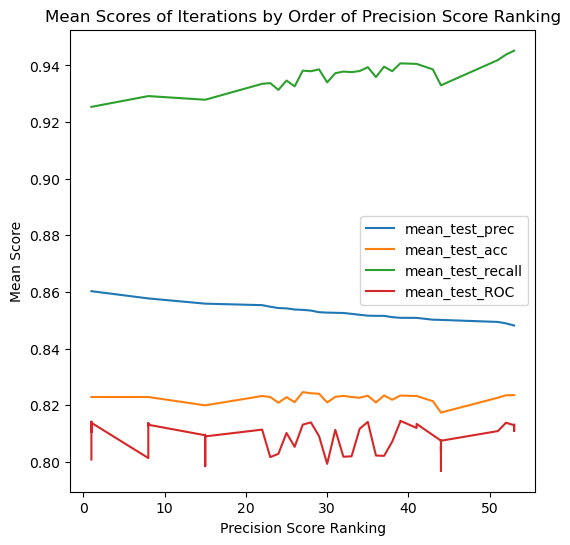

In [115]:
dt_clf_df.sort_values(by='rank_test_prec', inplace=True)

score_vars = [col for col in dt_clf_df.columns if ('mean_test' in col)]

fig, ax = plt.subplots(figsize=(6,6));

for i, col in enumerate(score_vars):
    ax.plot(dt_clf_df.rank_test_prec, dt_clf_df[col], label=col)

ax.set_xlabel('Precision Score Ranking');
ax.set_ylabel('Mean Score');
ax.set_title('Mean Scores of Iterations by Order of Precision Score Ranking');
ax.legend();

In [117]:
# Saves current best models scores and hyperparameters for later reference
best_model_scores = rankings(best_scorer_dt).loc[:, 2]
best_model_scores.rename('best_model', inplace=True)
best_model_params = dt_clf_grid.best_params_

As our precision drops our recall increases while our accuracy stays around the same. Even though we can see slight changes in the performance over these models, the scores only vary around one to two percentage points.

So far this is our best model, but it wasn't much of an improvement over our base model. Therefore let's try a different modeling method.

### Model 3

For this model will try using gradient boosting with XGBoost. Boosting is an iterative method that starts by building a weak model, and learning from it. This process is repeated until a stopping condition is met and our model is formed.

In [120]:
# Instantiate XGBClassifier
xgb_clf= XGBClassifier()

# Creates parameter grid for search
param_grid = {
    'learning_rate': [0.1, 0.2, .3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [.5, 1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

# creates gridsearch object using XGBoost as estimator
xgb_clf_grid = GridSearchCV(xgb_clf, param_grid,
                            scoring=scores,
                            return_train_score = True,
                            refit='prec')

# # fits xgb_clf to training data
# xgb_clf_grid.fit(X_train_scaled, y_train_flipped)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [0.5, 1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]},
             refit='prec', return_train_score=True,
             scoring={'ROC': 'roc_auc', 'acc': 'accuracy', 'prec': 'precision',
                      'recall': 'recall'})

In [121]:
# # Saves xgb_clf_grid model to prevent long run times
# with open('data/models/xgb_clf_grid.plk', 'wb') as f:
#     joblib.dump(xgb_clf_grid, f)

# Loads xgb_clf_grid model to prevent long run times
with open('data/models/xgb_clf_grid.plk', 'rb') as f:
    xgb_clf_grid = joblib.load(f)

In [122]:
xgb_clf_grid.best_score_

0.8594693565931427

Our new models performance of 86% is almost identical to our current best model. Lets check to see if this model is overfitting and how well it performed with the other scores

In [123]:
# Creates DataFrame of results
clf_boost_df = pd.DataFrame(xgb_clf_grid.cv_results_)

# Creates dataframe of best scorer row and trasposes it to a column
best_scorer_booster = clf_boost_df.loc[clf_boost_df.rank_test_prec==1, :].T

# displays DataFrame containing fold scores, mean score 
# and std_dev for both training and test set
fold_scores(best_scorer_booster, 'prec')

,test_24,train_24
split0_prec,0.855043,0.868291
split1_prec,0.863356,0.86388
split2_prec,0.86278,0.863967
split3_prec,0.857059,0.863307
split4_prec,0.85911,0.86298
mean_prec,0.859469,0.864485
std_prec,0.00321244,0.00193774


It appears that our model migh be slightly overfit with the training score being around .5% higher than our test scores.

In [124]:
# List rankings and means of all scoring metrics, and compares to current best model
pd.concat([rankings(best_scorer_booster), best_model_scores], axis=1)

,24,best_model
mean_test_prec,0.859469,0.860298
rank_test_prec,1,1
mean_train_prec,0.864485,0.860665
mean_test_acc,0.834782,0.822941
rank_test_acc,1,27
mean_train_acc,0.843332,0.823754
mean_test_recall,0.944538,0.925362
rank_test_recall,8,50
mean_train_recall,0.949864,0.926023
mean_test_ROC,0.82611,0.80087


This hyperparameter combination had the best precision and accuracy for this grid search. The recall and accuracy is also better than our previous best model as well at 94.4% and 83.4% respectively. Let's take a look at a figure showing the trend of scores as precision score drops.

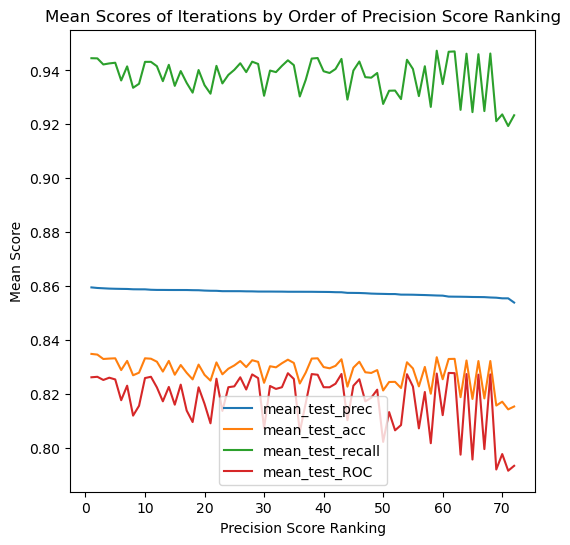

In [125]:
clf_boost_df.sort_values(by='rank_test_prec', inplace=True)

score_vars = [col for col in clf_boost_df.columns if ('mean_test' in col)]

fig, ax = plt.subplots(figsize=(6,6));

for i, col in enumerate(score_vars):
    ax.plot(clf_boost_df.rank_test_prec, clf_boost_df[col], label=col)

ax.set_xlabel('Precision Score Ranking');
ax.set_ylabel('Mean Score');
ax.set_title('Mean Scores of Iterations by Order of Precision Score Ranking');
ax.legend();

The above figure shows that as our precision drops, it seems like the rest of our score trend downwards as well. There is quite a bit of variance in the other scores in comparison to precision due to the varying hyperparameters.

This models precision was the same as our current best model while improving on the other test scores. For now this will replace our current best model.  

In [146]:
# Saves current best models scores and hyperparameters for later reference
best_model_scores = rankings(best_scorer_booster)
best_model_scores.rename(columns={best_model_scores.columns[0]: 'best_model'}, inplace=True)
best_model_params = xgb_clf_grid.best_params_

Since we still haven't seen much improvement on our base model, let's move on with another model.


## Model 4 - Random Forest

Random forest models combine multiple decision trees to decide the output. The output with the most decision trees predicting it is the one that is chosen overall for that entry. 

In [147]:
rf_clf = RandomForestClassifier(random_state=42, bootstrap=True)

param_grid_rf = {'n_estimators': (50, 100, 200, 400),
                 'criterion': ('gini', 'entropy', 'log_loss'),
                 'max_depth': (3, 4, 5, 6),
                 'max_samples': (.3, .5, .7)}

# creates gridsearch object using XGBoost as estimator
rf_clf_grid = GridSearchCV(rf_clf, 
                           param_grid_rf,
                           scoring=scores,
                           return_train_score = True,
                           refit='prec')

# fits RandomForest Grid Search to training data
rf_clf_grid.fit(X_train_ohe, y_train_flipped)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': (3, 4, 5, 6),
                         'max_samples': (0.3, 0.5, 0.7),
                         'n_estimators': (50, 100, 200, 400)},
             refit='prec', return_train_score=True,
             scoring={'ROC': 'roc_auc', 'acc': 'accuracy', 'prec': 'precision',
                      'recall': 'recall'})

In [148]:
# # Saves rf_clf_grid model to prevent long run times
# with open('data/models/rf_clf_grid.plk', 'wb') as f:
#     joblib.dump(rf_clf_grid, f)

# Loads rf_clf_grid model to prevent long run times
with open('data/models/rf_clf_grid.plk', 'rb') as f:
    rf_clf_grid = joblib.load(f)

In [149]:
rf_clf_grid.best_score_

0.8232916619884488

Our random forest model performed worse than our previous best models with a precision score of 82.3%, down from around 86%. Let's take a look at the parameters and folds of our best random forest model.

In [150]:
rf_clf_grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'max_samples': 0.7, 'n_estimators': 50}

In [151]:
# Creates DataFrame of results
rf_clf_df = pd.DataFrame(rf_clf_grid.cv_results_)

# Creates dataframe of best scorer row and trasposes it to a column
best_scorer_rf = rf_clf_df.loc[rf_clf_df.rank_test_prec==1, :].T

# displays DataFrame containing fold scores, mean score 
# and std_dev for both training and test set
fold_scores(best_scorer_rf, 'prec')

,test_44,train_44
split0_prec,0.820471,0.827631
split1_prec,0.824504,0.828423
split2_prec,0.82428,0.825081
split3_prec,0.823689,0.825247
split4_prec,0.823513,0.826223
mean_prec,0.823292,0.826521
std_prec,0.00145672,0.00131409


Our random forest model isn't overfitting at the set hyperparameters. Our random forest model performs best with a max depth of 6, 200 estimators and while sampling half of our entries each time. Let's see how this model performed on the other scoring metrics. 

In [152]:
# List rankings and means of all scoring metrics, and compares to current best model
pd.concat([rankings(best_scorer_rf), best_model_scores], axis=1)

,44,best_model
mean_test_prec,0.823292,0.859469
rank_test_prec,1,1
mean_train_prec,0.826521,0.864485
mean_test_acc,0.818163,0.834782
rank_test_acc,1,1
mean_train_acc,0.823436,0.843332
mean_test_recall,0.979145,0.944538
rank_test_recall,144,8
mean_train_recall,0.981744,0.949864
mean_test_ROC,0.818557,0.82611


While this model performed a few percentage points worse in precision than our best model so far, it has the highest recall score at .98, meaning it captures around 98% of our non-vaccinated entries. Our concentration is on the precision score of our model, since this one performed poorly in that regard it will not replace our best model.

So far out models have been focused around types of decision trees, for our next model let's try something different.

## Model 5

For the next model we will try a Logistic Regression model. Similarly to linear regression, logistic regression uses a loss function to help predict the target. 

In [153]:
lr_clf = LogisticRegression(random_state=42)

param_grid_lr = {'penalty': ('l1', 'l2'),
                 'C': (.1, 1, 10),
                 'solver': ['liblinear'],
                 'max_iter': [200]}

# creates gridsearch object using XGBoost as estimator
lr_clf_grid = GridSearchCV(lr_clf, 
                           param_grid_lr,
                           scoring=scores,
                           return_train_score = True,
                           refit='prec')

# fits RandomForest Grid Search to training data
lr_clf_grid.fit(X_train_ohe, y_train_flipped)

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': (0.1, 1, 10), 'max_iter': [200],
                         'penalty': ('l1', 'l2'), 'solver': ['liblinear']},
             refit='prec', return_train_score=True,
             scoring={'ROC': 'roc_auc', 'acc': 'accuracy', 'prec': 'precision',
                      'recall': 'recall'})

In [154]:
# Saves lr_clf_grid model to prevent long run times
with open('data/models/lr_clf_grid.plk', 'wb') as f:
    joblib.dump(lr_clf_grid, f)

# Loads rf_clf_grid model to prevent long run times
# with open('data/models/lr_clf_grid.plk', 'rb') as f:
#     lr_clf_grid = joblib.load(f)

In [155]:
lr_clf_grid.best_score_

0.8520979823438315

Our logistic regression model performed a little bit worse than our best model at 85.2% precision compared to 86%. Let's check its other scores.

In [156]:
# Creates DataFrame of results
lr_clf_df = pd.DataFrame(lr_clf_grid.cv_results_)

# Creates dataframe of best scorer row and trasposes it to a column
best_scorer_lr = lr_clf_df.loc[lr_clf_df.rank_test_prec==1, :].T

# List rankings and means of all scoring metrics, and compares to current best model
pd.concat([rankings(best_scorer_lr), best_model_scores], axis=1)

,5,best_model
mean_test_prec,0.852098,0.859469
rank_test_prec,1,1
mean_train_prec,0.853036,0.864485
mean_test_acc,0.828683,0.834782
rank_test_acc,2,1
mean_train_acc,0.830132,0.843332
mean_test_recall,0.946669,0.944538
rank_test_recall,5,8
mean_train_recall,0.947411,0.949864
mean_test_ROC,0.820898,0.82611


Comparing the scoring metrics to our best model, the logistic regression model performed worse except for recall. Therefore our best model will stay the same.

### Final Model

Our best model is the XGBoosted model with the following parameters.

In [157]:
best_model_params

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 0.5,
 'n_estimators': 100,
 'subsample': 0.5}

Let's train this model on our full training set and check how it performs on our test set.

In [200]:
# Creates XGBoost Classifier object with best model params
final_model = XGBClassifier(learning_rate=.2,
                            max_depth=3,
                            min_child_weight=.5,
                            n_estimators=100,
                            subsample=.5,
                            random_state=42)

# fits classifier to training dataset
final_model.fit(X_train_scaled, y_train_flipped);

In [201]:
# Finds predicted values for train and test sets
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

In [203]:
def quick_metrics(y_true, y_pred):
    '''
    Displays confusion matrix and classification report
    
    Inputs: y_true = real labels
            y_pred = predicted labels
    '''
    
#     Generates confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     Creates and displays dataframe for easier viewing of confusion matrix
    display(pd.DataFrame(data=cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1']))    
    print()
#     creates classification_report dictionary
    cr_dict = classification_report(y_true, y_pred, output_dict=True)
#     displays metrics for our non-vaccinated predictions
    acc = cr_dict['accuracy']
    print(f'Accuracy: {acc}')
    display(cr_dict['1'])

In [196]:
# Prints out confusion matrix and metric report for training set
quick_metrics(y_train_flipped, y_train_pred)

,pred_0,pred_1
true_0,1859,2330
true_1,774,14714



Accuracy: 0.8422523758703054


{'precision': 0.8632950011734335,
 'recall': 0.950025826446281,
 'f1-score': 0.9045862535349809,
 'support': 15488}

In [202]:
# Prints out confusion matrix and metric report for test set
y_test_flipped = binary_flip(y_test_mod)
quick_metrics(y_test_flipped, y_test_pred)

,pred_0,pred_1
true_0,597,801
true_1,268,4897



Accuracy: 0.8371171720249886


{'precision': 0.8594243594243595,
 'recall': 0.9481122942884802,
 'f1-score': 0.9015925619073921,
 'support': 5165}

## References

[1] <a id='h1n1_cdc_article' href='https://www.cdc.gov/flu/pandemic-resources/2009-h1n1-pandemic.html'>https://www.cdc.gov/flu/pandemic-resources/2009-h1n1-pandemic.html</a>

[2] <a id='About the National Immunization Survery' href="https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1">https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1</a>

[3] <a href='https://www.drivendata.org/competitions/66/flu-shot-learning/data/'>https://www.drivendata.org/competitions/66/flu-shot-learning/data/</a>

[4] <a id='Missing Data Imputation using Regression' href='https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression'>https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression</a>

# Code Testing

In [ ]:
# ohe.get_feature_names(X_train_imp.drop(missing_columns, axis=1).columns)

# Wrote but not forgotten

possible add backs later

In [ ]:
# features_of_interest = ['h1n1_concern', 
#                         'h1n1_knowledge', 
#                         'doctor_recc_h1n1', 
#                         'chronic_med_condition', 
#                         'health_worker', 
#                         'age_group', 
#                         'education']

# for feature in features_of_interest:
#     quick_feature_info(X[feature], y)
#     print(f'{feature}\n')

In [ ]:
# Grabs numberical columns from training set
X_train_num = X_train_mod.select_dtypes(include=['int64', 'float64']).copy()

def scatter_plots(X, n_cols, y='index'):
    '''
    Creates scatter plots for each feature in X against y
    Handles missing values of type Nan 
    
    Inputs: X = dataframe to have features plotted
            y = dataseries to be plotted against,
                default=index
            ncols = number of columns for figure
    Output: [# of features//ncols, ncols] sized figure of scatterplots
    '''
#     Calculates number of rows in figure
    n_rows = (X.shape[1]//n_cols)+1
    
#     Creates figure
    fig, axes = plt.subplots(figsize = (n_cols*5, n_rows*5),
                                  ncols=n_cols,
                                  nrows=n_rows);
#     Plots individual scatter plots
    for i, col in enumerate(X.columns):
        if type(y) == str:
            ind = range(X[col].notna().sum())
            axes[i//n_cols, i%n_cols].scatter(ind, X[col].dropna());
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y}');
        else:
            temp_df = pd.concat([X[col], y], axis=1).dropna()
            axes[i//n_cols, i%n_cols].scatter(temp_df.iloc[:,1], temp_df.iloc[:,0]);
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y.name}');
                        